# TabNet 코드 구현1

TabNet공부를 위해 [해당 유튜브 영상](https://www.youtube.com/watch?v=ysBaZO8YmX8&ab_channel=AbhishekThakur) 를 참조해서 공부를 해보았다.

### 1. import Library

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

(**pip install pytorch-tabnet 명령어를 사용하여 환경에 tabnet libraray를 먼저 설치해준다.)

### 2. Data Load
실험을 위해 사용한 데이터는 [census-income dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/) 이다.
<br>census-income data는 income(소득)이 50k를 초과하는지 아닌지에 대해 binary classification할수 있는 dataset이다.
<br>마지막 41번째 feature가 income에 해당하는 target feature 이다.
<br>test : valid : test = 80 : 10 : 10 으로 나누어준다.


In [2]:
train = pd.read_csv('.\data\census-income.data',header=None)
pd.set_option('display.max_columns', None)
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,Not in universe,0,0,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Not in labor force,0,0,0,Joint both 65+,Not in universe,Not in universe,Householder,Householder,955.27,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Canada,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
199519,65,Self-employed-incorporated,37,2,11th grade,0,Not in universe,Married-civilian spouse present,Business and repair services,Executive admin and managerial,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,6418,0,9,Joint one under 65 & one 65+,Not in universe,Not in universe,Householder,Householder,687.19,Nonmover,Nonmover,Nonmover,Yes,Not in universe,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
199520,47,Not in universe,0,0,Some college but no degree,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,157,Joint both under 65,Not in universe,Not in universe,Householder,Householder,1923.03,?,?,?,Not in u

In [12]:
target = 41
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train","valid","test"], p = [.8, .1, .1], size = (train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

### 3. Data Preprocessing

- TabNet은 입력으로 사용할 데이터가 categorical인지 Numerical인지 지정을 해주어야한다.(Categorical변수인경우 Embedding을 해주는 단계가 있기 때문에)
- 따라서 아래 코드에서 (1)unique한 값이 200개 이하이면 categorical 변수로 변환하고 200개 이상인 경우 numerical로 판단하여 Null value를 평균값으로 대체한다.
- 그리고 코드에서 embedding을 위해 categorical 변수라는 것을 지정해주기 위해 (2) cat_idxs와 cat_dims를 저장해두었다.

In [13]:
nunique = train.nunique() # 데이터에 고유값들의 수를 출력해주는 함수
types = train.dtypes

categorical_columns = []
categorical_dims = {}

for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200 :
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)
    
'''아래코드는 categorical embedding을 위한 전처리 부분 ( categorical 변수 dimension, idxs )'''
unused_feat = ['Set']
features = [col for col in train.columns if col not in unused_feat+[target]]
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

0 91
1 9
2 52
3 47
4 17
6 3
7 7
8 24
9 15
10 5
11 10
12 2
13 3
14 6
15 8
16 132
17 113
19 6
20 6
21 51
22 38
23 8
25 10
26 9
27 10
28 3
29 4
30 7
31 5
32 43
33 43
34 43
35 5
36 3
37 3
38 3
39 53
40 2
41 2
Set 3


### 4. Model Define
TabNet Classifier Define을 함.<br>
cat_idxs -> 카테고리 변수의 위치<br>
cat_dims -> 각 카테고리 변수의 카디널리티<br>
cat_emb_dim -> 카테고리 변수의 임베딩 사이즈를 의미<br>
optimizer -> Adam<br>
sheduler -> lr_sheduler<br>
mask type -> sparsemax<br>

In [14]:
clf = TabNetClassifier(
    cat_idxs=cat_idxs, 
    cat_dims = cat_dims,
    cat_emb_dim=10,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-2),
    scheduler_params={"step_size":50, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler .StepLR,
    mask_type='sparsemax' #entmax함수도 살펴보기
)

Device used : cuda


In [15]:
X_train.shape

(159777, 41)

In [16]:
max_epochs = 15

clf.fit(
    X_train=X_train, y_train = y_train,
    eval_set = [(X_train, y_train), (X_valid, y_valid)],
    eval_name = ['train','valid'],
    eval_metric = ['auc'],
    max_epochs = max_epochs, patience = 20,
    batch_size = 1024, virtual_batch_size = 128,
    num_workers = 0,
    weights = 1,
    drop_last = False
)

epoch 0  | loss: 0.51683 | train_auc: 0.89337 | valid_auc: 0.89176 |  0:00:10s
epoch 1  | loss: 0.36635 | train_auc: 0.92451 | valid_auc: 0.91901 |  0:00:19s
epoch 2  | loss: 0.34151 | train_auc: 0.93139 | valid_auc: 0.92584 |  0:00:28s
epoch 3  | loss: 0.32557 | train_auc: 0.93766 | valid_auc: 0.93286 |  0:00:37s
epoch 4  | loss: 0.30982 | train_auc: 0.94467 | valid_auc: 0.94052 |  0:00:46s
epoch 5  | loss: 0.2976  | train_auc: 0.94961 | valid_auc: 0.94301 |  0:00:55s
epoch 6  | loss: 0.2829  | train_auc: 0.95302 | valid_auc: 0.9435  |  0:01:04s
epoch 7  | loss: 0.27166 | train_auc: 0.95704 | valid_auc: 0.94629 |  0:01:13s
epoch 8  | loss: 0.26614 | train_auc: 0.95846 | valid_auc: 0.94638 |  0:01:22s
epoch 9  | loss: 0.26042 | train_auc: 0.95969 | valid_auc: 0.94468 |  0:01:30s
epoch 10 | loss: 0.25573 | train_auc: 0.96215 | valid_auc: 0.94482 |  0:01:40s
epoch 11 | loss: 0.24785 | train_auc: 0.96297 | valid_auc: 0.94303 |  0:01:49s
epoch 12 | loss: 0.24596 | train_auc: 0.96489 | vali

In [17]:
preds = clf.predict_proba(X_test)
test_auc=roc_auc_score(y_score=preds[:,1], y_true=y_test)

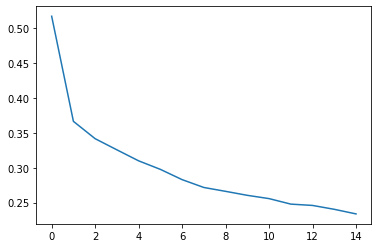

In [18]:
plt.plot(clf.history['loss'])

KeyError: 'val_auc'

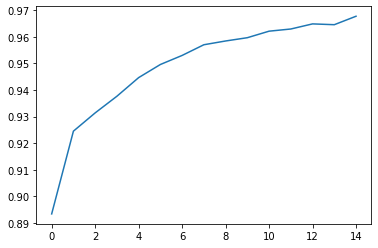

In [19]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['val_auc'])

In [ ]:
plt.plot(clf.history['lr'])

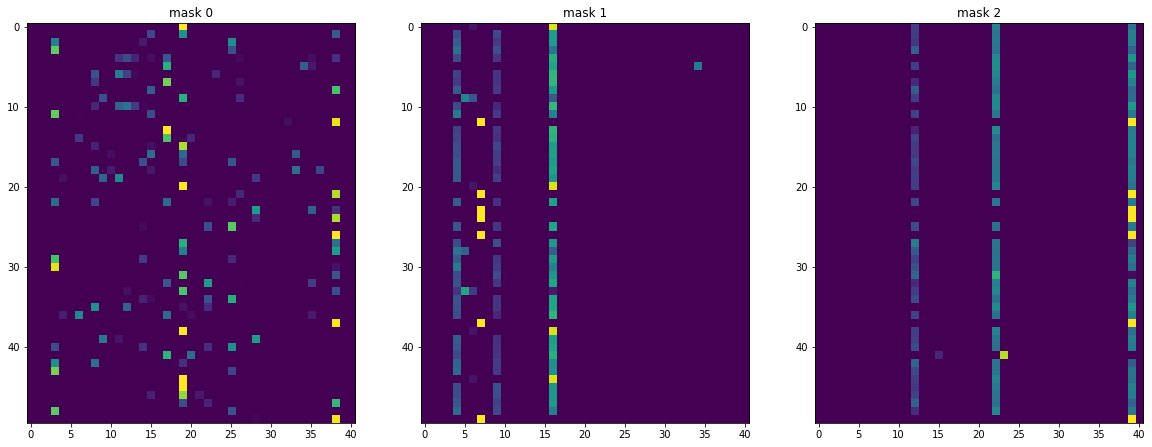

In [25]:
explain_matrix, masks = clf.explain(X_test)

fig, axs = plt.subplots(1,3, figsize=(20,20))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")